In [8]:
import numpy as np
import pandas as pd

import ipywidgets as widgets
from IPython.display import display, clear_output

import plotly.express as px

import matplotlib.pyplot as plt

import seaborn as sns

import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "iframe_connected"

In [ ]:
import numpy as np
import torch
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, pipeline
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from ipywidgets import interact
import plotly.graph_objects as go



In [9]:
df_combined = pd.read_csv('../aggregated_data/combined_review_data_with_sentiment.csv')

# **Exploratory Data Analysis**

In [10]:
#| echo: true

import plotly.graph_objects as go

# --------------------------
# Clean your data
# --------------------------
df_combined['review'] = df_combined['review'].astype(str)
df_combined['data_source'] = df_combined['data_source'].astype(str).str.strip().str.title()
df_combined['app_name'] = df_combined['app_name'].astype(str).str.strip().str.capitalize()

# --------------------------
# Define variables
# --------------------------
target_apps = ['Ubereats', 'Doordash', 'Grubhub']
target_sources = ['Reddit', 'Google Play', 'App Store']
colors_app = ['green', 'red', 'orange']
colors_source = ['red', 'green', 'blue']

# --------------------------
# Create traces for data sources
# --------------------------
source_traces = []
for source in sorted(df_combined['data_source'].unique()):
    df_filtered = df_combined[df_combined['data_source'] == source]
    counts = df_filtered['app_name'].value_counts().to_dict()
    x_vals = [counts.get(app, 0) for app in target_apps]
    source_traces.append(go.Bar(
        x=x_vals,
        y=target_apps,
        orientation='h',
        marker_color=colors_app,
        name=source,
        visible=False
    ))

# --------------------------
# Create traces for app names
# --------------------------
app_traces = []
for app in sorted(df_combined['app_name'].unique()):
    df_filtered = df_combined[df_combined['app_name'] == app]
    counts = df_filtered['data_source'].value_counts().to_dict()
    x_vals = [counts.get(src, 0) for src in target_sources]
    app_traces.append(go.Bar(
        x=x_vals,
        y=target_sources,
        orientation='h',
        marker_color=colors_source,
        name=app,
        visible=False
    ))

# Combine traces
all_traces = source_traces + app_traces

# --------------------------
# Create dropdown buttons
# --------------------------
buttons = []

# Buttons for data sources
for i, source in enumerate(sorted(df_combined['data_source'].unique())):
    visibility = [False] * len(all_traces)
    visibility[i] = True
    buttons.append(dict(
        label=f"Source: {source}",
        method='update',
        args=[{'visible': visibility},
              {'title': f"Review Counts in {source}",
               'xaxis': {'title': 'Number of Reviews'},
               'yaxis': {'title': 'App'}}]
    ))

# Buttons for app names
for j, app in enumerate(sorted(df_combined['app_name'].unique())):
    visibility = [False] * len(all_traces)
    visibility[len(source_traces) + j] = True
    buttons.append(dict(
        label=f"App: {app}",
        method='update',
        args=[{'visible': visibility},
              {'title': f"{app} Review Counts by Data Source",
               'xaxis': {'title': 'Number of Reviews'},
               'yaxis': {'title': 'Data Source'}}]
    ))

# --------------------------
# Build the figure
# --------------------------
fig = go.Figure(data=all_traces)

# Set initial trace visible
fig.data[0].visible = True

fig.update_layout(
    updatemenus=[dict(
        active=0,
        buttons=buttons,
        direction='down',
        x=0.5,
        xanchor='center',
        y=1.2,
        yanchor='top'
    )],
    title="Review Counts in " + sorted(df_combined['data_source'].unique())[0],
    xaxis_title='Number of Reviews',
    yaxis_title='App',
    height=500,
    plot_bgcolor='white'
)

fig.show()


This dashboard presents a side-by-side comparison of review volumes by app and by data source.

The left chart displays the total number of reviews submitted for each food delivery app (UberEats, DoorDash, GrubHub) within the selected data source (e.g., Reddit).

The right chart highlights how many reviews a selected app has received across multiple platforms (App Store, Google Play, Reddit).

This dual-panel visualization helps assess both platform-specific popularity and app-level customer engagement, offering insights into where users are most vocal and which platforms generate the most feedback.

In [11]:
#| echo: true

# Prepare data
df_combined1 = df_combined.copy()
df_combined1['review_datetime'] = pd.to_datetime(df_combined1['review_datetime'], errors='coerce')
df_combined1['month_year'] = df_combined1['review_datetime'].dt.to_period('M').astype(str)

# Group by app and month
monthly_reviews = df_combined1.groupby(['app_name', 'month_year']).size().reset_index(name='review_count')

# Create Plotly line plot
fig = px.line(
    monthly_reviews,
    x='month_year',
    y='review_count',
    color='app_name',
    markers=True,
    title='Monthly Review Counts per App',
    labels={
        'month_year': 'Month-Year',
        'review_count': 'Number of Reviews',
        'app_name': 'App Name'
    },
    hover_name='app_name',
    hover_data={'month_year': True, 'review_count': True}
)

# Beautify layout
fig.update_layout(
    xaxis_tickangle=-45,
    width=1000,
    height=600,
    plot_bgcolor='white',
    hovermode='x unified',
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True)
)

# Show plot
fig.show()


This line chart illustrates the monthly trend in the number of customer reviews received by three major food delivery apps: UberEats, DoorDash, and GrubHub. The x-axis represents time in month-year format, while the y-axis shows the number of reviews submitted during each period. By tracking this timeline, the chart reveals seasonal patterns, spikes in user engagement, or dips in activity for each app. This visualization helps compare overall app popularity and review volume over time.

In [12]:
#| echo: true


df_combined1 = df_combined.copy()
df_combined1['review_datetime'] = pd.to_datetime(df_combined1['review_datetime'], errors='coerce')
df_combined1['month_year'] = df_combined1['review_datetime'].dt.to_period('M').astype(str)

# Group by data_source and month_year
monthly_reviews_source = df_combined1.groupby(['data_source', 'month_year']).size().reset_index(name='review_count')



fig = px.line(
    monthly_reviews_source,
    x='month_year',
    y='review_count',
    color='data_source',
    markers=True,
    title='Monthly Review Counts per Data Source',
    labels={
        'month_year': 'Month-Year',
        'review_count': 'Number of Reviews',
        'data_source': 'Data Source'
    },
    hover_name='data_source',
    hover_data={'month_year': True, 'review_count': True}
)

fig.update_layout(
    xaxis_tickangle=-45,
    width=1000,
    height=600,
    plot_bgcolor='white',
    hovermode='x unified'
)

fig.show()


This line chart tracks the monthly volume of customer reviews submitted through different data sources: App Store, Google Play, and Reddit. The x-axis represents the timeline in month-year format, while the y-axis displays the number of reviews collected each month. This visualization reveals platform-specific trends in review activity, such as steady engagement from Google Play, increasing contributions from Reddit, and consistently lower volume from the App Store. It helps highlight how different platforms contribute to user feedback over time.

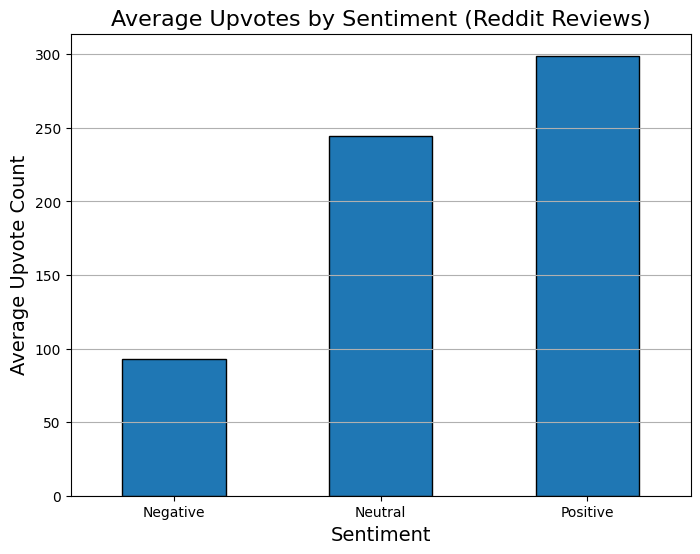

In [13]:
#| echo: true
reddit_reviews = df_combined[df_combined['data_source'] == 'Reddit']

# Group by sentiment
upvotes_by_sentiment = reddit_reviews.groupby('sentiment')['upvote_count'].mean()

# Plot
upvotes_by_sentiment.plot(kind='bar', figsize=(8,6), edgecolor='black')
plt.title('Average Upvotes by Sentiment (Reddit Reviews)', fontsize=16)
plt.ylabel('Average Upvote Count', fontsize=14)
plt.xlabel('Sentiment', fontsize=14)
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.show()


The above bar plot visualizes how upvotes are related to sentiments of the user. Here the plot shows how many upvotes were there for a review under given snetiment( Negative, Positive, Neutral)

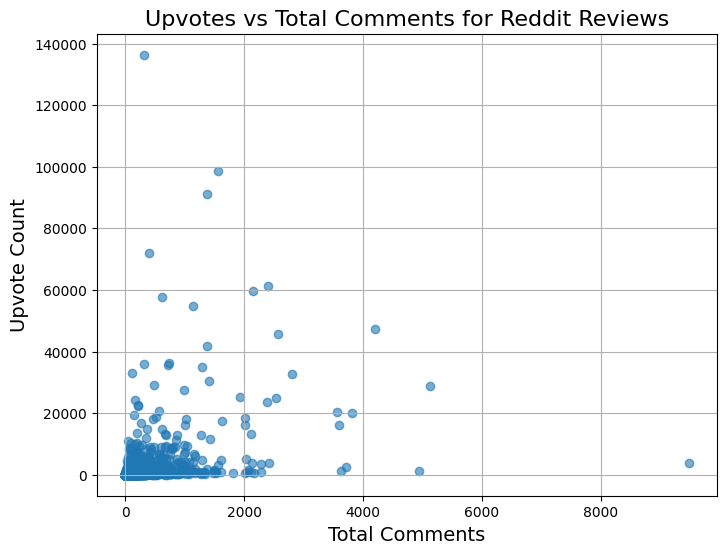

In [14]:
#| echo: true
plt.figure(figsize=(8,6))
plt.scatter(reddit_reviews['total_comments'], reddit_reviews['upvote_count'], alpha=0.6)
plt.title('Upvotes vs Total Comments for Reddit Reviews', fontsize=16)
plt.xlabel('Total Comments', fontsize=14)
plt.ylabel('Upvote Count', fontsize=14)
plt.grid(True)
plt.show()
